### Transformer is all you need

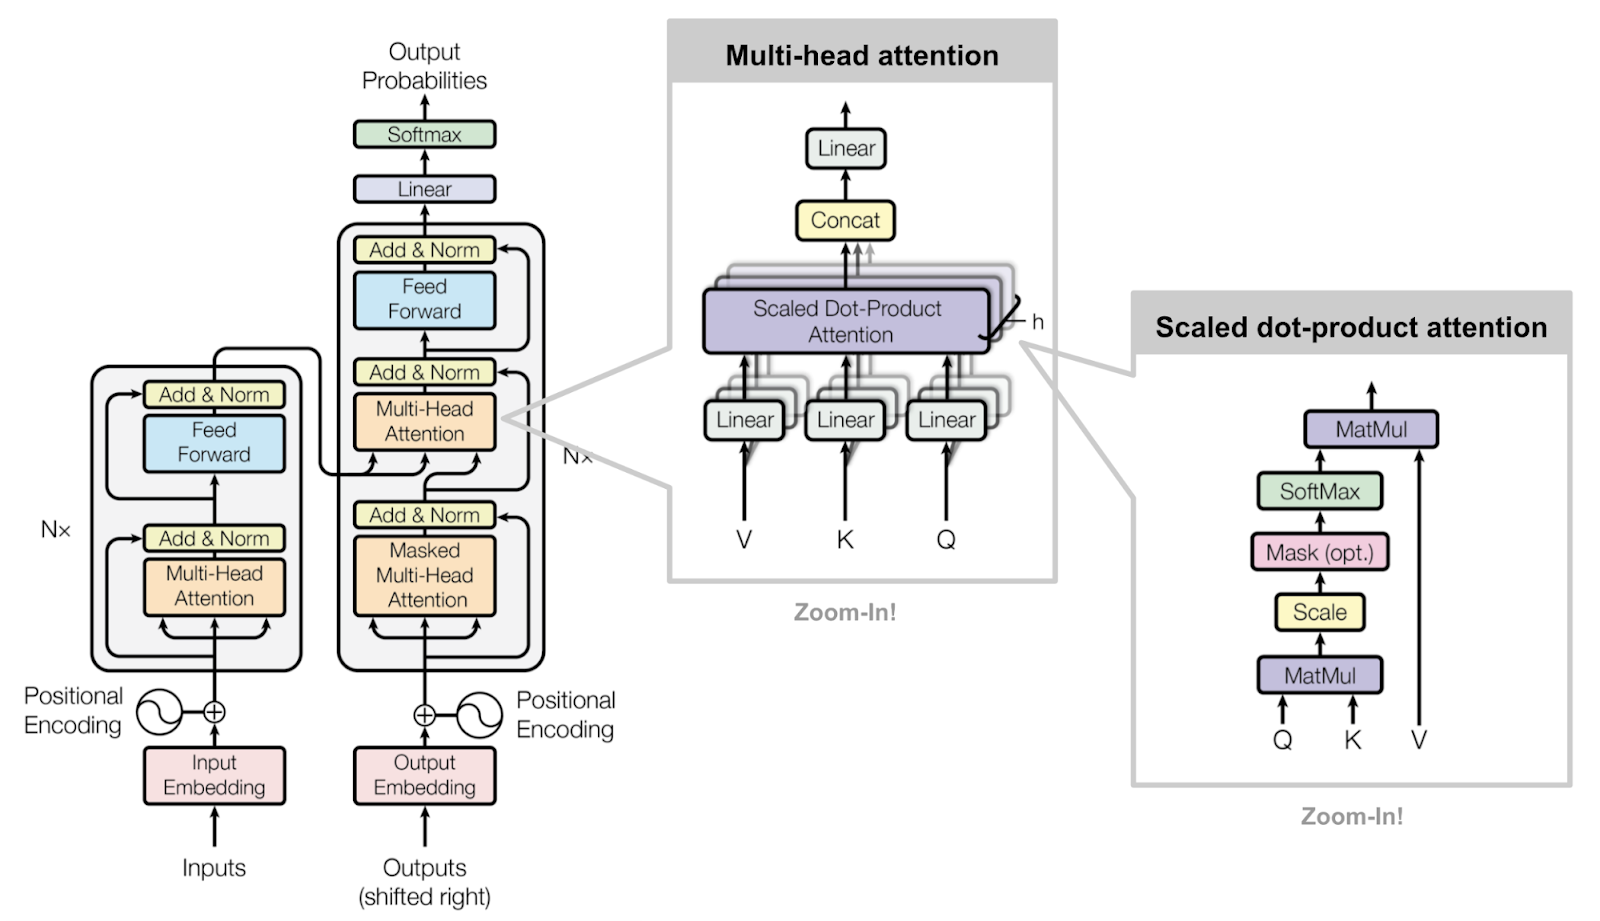

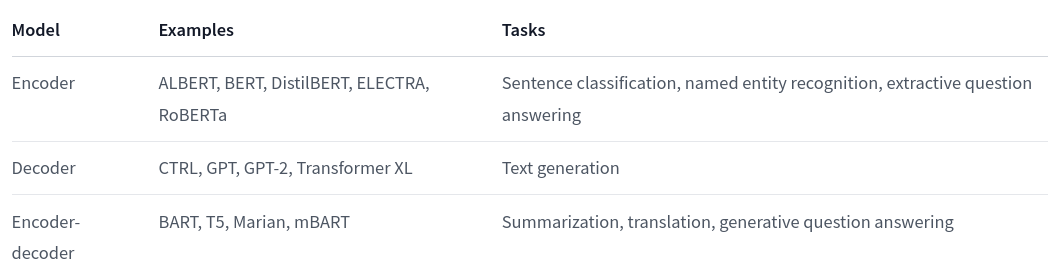
https://huggingface.co/learn/nlp-course/chapter1/9?fw=pt

In [1]:
context_length = 16
embedding_dim = 3
vocab_size = 32000
padding_index = 2
input_text = "Jack was hungry, so he went looking for"

In [2]:
import torch
from torch import nn

In [3]:
# Tokenize
from src.tokenize.tokenizer import Tokenizer

TOKENIZER_CHECKPOINT = (
    "/home/pranav-pc/projects/OpenTransformer/multiformer/tokenizer_checkpoints/"
)
tokenizer = Tokenizer(TOKENIZER_CHECKPOINT)
print(tokenizer.encode(input_text, out_type=str))
tokenized_text = tokenizer.encode(input_text)
print(tokenized_text)

['<s>', '▁Jack', '▁was', '▁hun', 'gry', ',', '▁so', '▁he', '▁went', '▁looking', '▁for', '</s>']
[1, 5457, 471, 9074, 14793, 29892, 577, 540, 3512, 3063, 363, 2]


In [4]:
tokenized_text = tokenized_text + [
    padding_index for _ in range(context_length - len(tokenized_text))
]
tokenized_text = torch.tensor(tokenized_text).view(1, -1)
tokenized_text

tensor([[    1,  5457,   471,  9074, 14793, 29892,   577,   540,  3512,  3063,
           363,     2,     2,     2,     2,     2]])

In [5]:
x = tokenized_text[:, :-1]
y = tokenized_text[:, 1:]
x, y

(tensor([[    1,  5457,   471,  9074, 14793, 29892,   577,   540,  3512,  3063,
            363,     2,     2,     2,     2]]),
 tensor([[ 5457,   471,  9074, 14793, 29892,   577,   540,  3512,  3063,   363,
              2,     2,     2,     2,     2]]))

- Rule based tokenizer : 
    E.g., Transformer XL uses space and punctuation tokenization, resulting in a vocabulary size of 2,67,735!
    - Out of vocabulary 
- Character tokenization
    much harder for the model to learn meaningful input representations. 
- Subword tokenizer
    rare words should be decomposed into meaningful subwords

- Byte-Pair Encoding (BPE)
    Eg -  GPT has a vocabulary size of 40,478 since they have 478 base characters and chose to stop training after 40,000 merges.
- Byte-level BPE
    e.g. all unicode characters are considered as base characters.  GPT-2 has a vocabulary size of 50,257,which corresponds to the 256 bytes base tokens, a special end-of-text token and the symbols learned with 50,000 merges.
- WordPiece
    WordPiece does not choose the most frequent symbol pair, but the one that maximizes the likelihood of the training data 
    WordPiece is the subword tokenization algorithm used for BERT, DistilBERT, and Electra.
- Unigram
- SentencePiece

In [6]:
# Link to benchmark test
# http://localhost:8888/notebooks/projects/OpenTransformer/multiformer/notebooks/data-prep/benchmark-tokenizer.ipynb

In [7]:
embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_index)
x = embedding(tokenized_text)
x

tensor([[[-1.6062, -1.6081, -1.5415],
         [ 0.8759,  1.1610,  0.0842],
         [-0.2833, -0.0671, -0.2476],
         [ 0.1125,  0.3781,  1.2833],
         [ 0.8662,  1.8694,  1.7714],
         [ 0.6952,  0.1262, -1.4273],
         [ 0.0548, -0.6435,  1.3075],
         [ 1.9737, -2.2420, -0.2041],
         [ 0.6745,  1.3821, -0.3319],
         [-1.5442, -0.5372, -0.3758],
         [-0.6282,  0.9348,  0.1677],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000]]], grad_fn=<EmbeddingBackward0>)

In [8]:
pos_embedding = nn.Embedding(context_length, embedding_dim, padding_idx=padding_index)(
    torch.tensor(range(context_length))
)
pos_embedding

tensor([[ 1.0922,  0.3396, -1.0294],
        [ 1.1624, -0.7714,  0.3442],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0505, -0.4887, -0.2795],
        [-1.1800,  0.0310, -0.7558],
        [ 0.9092, -0.0231, -0.0580],
        [ 0.1696,  1.9945,  1.6145],
        [-0.4472,  1.0601,  0.0084],
        [ 0.9157, -0.3422, -0.5969],
        [-0.5280, -2.0508,  0.0853],
        [ 1.5667, -0.1711,  0.9828],
        [-0.0355, -0.6518, -0.9272],
        [ 0.7395, -1.1558,  0.1934],
        [ 0.8924,  0.1660,  0.1211],
        [-0.2864, -0.9955,  1.1600],
        [-3.1746,  0.7665, -1.4526]], grad_fn=<EmbeddingBackward0>)

In [9]:
x += pos_embedding
x.shape

torch.Size([1, 16, 3])

In [10]:
from src.cells.normalization import LayerNorm

x = LayerNorm(ndim=embedding_dim, bias=True)(x)
x.shape

torch.Size([1, 16, 3])

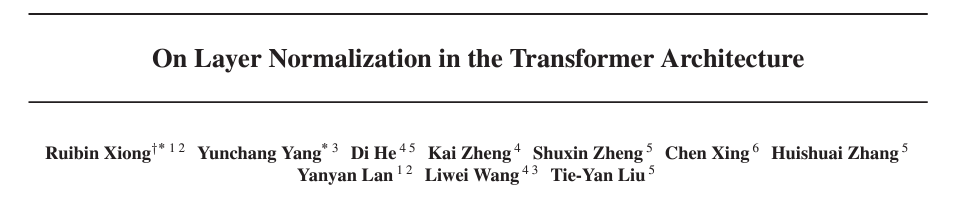

In [11]:
attn = nn.functional.scaled_dot_product_attention(
    x,
    x,
    x,
    attn_mask=None,
    dropout_p=0.0,
    is_causal=True,
)
attn.shape

torch.Size([1, 16, 3])

In [12]:
x += attn

In [13]:
x = LayerNorm(ndim=embedding_dim, bias=True)(x)
x.shape

torch.Size([1, 16, 3])

In [14]:
from src.cells.feedforward import FeedForward

In [15]:
x = FeedForward(d_model=embedding_dim, d_ff=2 * embedding_dim)(x)
x.shape

torch.Size([1, 16, 3])

In [16]:
out = nn.Linear(embedding_dim, vocab_size)
out.weight = embedding.weight

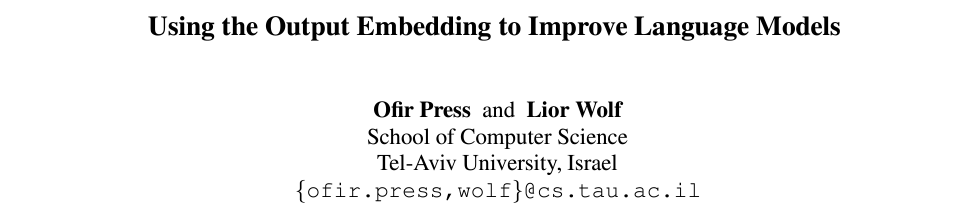
https://paperswithcode.com/method/weight-tying

In [17]:
x.shape, y.shape

(torch.Size([1, 16, 3]), torch.Size([1, 15]))

In [18]:
x = out(x)
x.shape

torch.Size([1, 16, 32000])

In [19]:
logits = nn.functional.softmax(x, dim=-1)
logits.shape

torch.Size([1, 16, 32000])

In [20]:
logits[:, -1, :]

tensor([[1.2464e-05, 1.4456e-05, 1.7963e-05,  ..., 1.1731e-05, 3.5414e-05,
         1.1312e-05]], grad_fn=<SliceBackward0>)

In [21]:
next_token = torch.multinomial(logits[:, -1, :], num_samples=1)
next_token

tensor([[27833]])

In [22]:
tokenizer.decode_ids(19190)

'stage'

In [23]:
from src.inference.blm_generate import predict

predict(input_text)

Seed set to 123
Seed set to 123


Jack was hungry, so he went looking for something to eat. He looked in the kitchen and saw a big pot. He was so happy! He grabbed the pot and put it on the stove. Then he heard a loud noise. He opened the door and saw a big, red apple. He was so excited! He grabbed the apple and took a big bite. It was so yummy! He ate the rest of the apple and it was so good.

Jack was so happy he found the pot of apple. He wanted to eat the apple again, so he grabbed the pot and went outside to play. He ran around and had so much fun!

When it was time to go home, Jack grabbed his pot of apple and put it in his pocket. He was so happy he found it. Now he had a yummy apple to eat and he was ready for the next adventure tomorrow.




In [28]:
input_text = (
    "Lily wanted to get either a cat or a dog. Her mother didn’t let her get a dog so instead she"
)
predict(input_text)

Lily wanted to get either a cat or a dog. Her mother didn’t let her get a dog so instead she had to go to school. Lily was very sad, but she knew she could still get a cat and a dog.

On her first day at school, Lily saw a boy with a dog and a girl with a cat. She was so excited and wanted to play with them. She asked the boy if she could pet the dog and he said yes.

Lily was very happy and ran to the boy and the girl to say hello. But when she got there, she saw that the boy and his dog were not friendly. He was being very rude and wouldn't let her pet his dog. Lily was very upset and ran to the boy and the girl's mom. She told them to be nice to the boy and his dog and to be friendly.

Lily was so sad that she started to cry. She didn't understand why the boy and his dog were being so rude. She wished she could go back to school and play with them. She wished she could go home and forget about the boy and the dog.

Then her mother came to the boy and the girl and said, "Why are you 